# PySpark - GeoPandas Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook to investigate using GeoPandas for spatial data operations and PySpark to (potentially) run them on a compute cluster. This could be useful for processing large datasets of species observations.

Note that installation is slightly tricky due to the mixing of Python with the JVM (Scala/Java) based Spark and the use of latest developments for bridging them (in pyspark, such as Apache Arrow). Transporting spatial data between both environments adds some additional complexity. This notebook is tested with Spark 3.4.0 (currently the latest version).

In this notebook species observation data from NDFF is used. For more information about this data please contact NDFF or visit their website (be aware that it is not fully available in English).

**Data source(s)**:
- ['Nationale Databank Flora en Fauna'](https://ndff.nl) (October 2022). This data is copy protected.

### Import Packages
Some imports are for future use :-)

Hint: Make sure pyspark package version matches the installed Apache Spark version!

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas.geoseries
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 5)

# for exponential back down when calling APIs
from retrying import retry

# PySpark libraries
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DecimalType
from pyspark.sql import SparkSession

# Spatial pandas libraries
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, shape
from shapely import wkb, wkt

# Used to decode data from Java
from ast import literal_eval as make_tuple

ModuleNotFoundError: No module named 'pyspark'

### Create a Spark Session

In [2]:
spark = SparkSession.builder.appName("fairicube-geopandas").getOrCreate()
sc = spark.sparkContext
sc

23/07/28 11:27:34 WARN Utils: Your hostname, robs-m1pro.local resolves to a loopback address: 127.0.0.1; using 192.168.68.102 instead (on interface en0)
23/07/28 11:27:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/28 11:27:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=fairicube-geopandas>

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [3]:
# the NDFF datafile to process
#
# Note that these csv files were specifically prepared for this study, and
# other NDFF datasets likely don't have the same columns so will require
# pre-processing first!
#
# Available datasets:
# broedvogels_2016.csv      (observations of nesting birds in 2016)
# overigesoorten_2016.csv   (observations of 'other' species in 2016)
# planten_2016.csv          (observations of plants in 2016)
#

# when working with the S3 bucket:
base_input_file_path = "~/s3/uc2-data"
base_output_file_path = "~/s3/uc2-data"

# when running locally
#base_input_file_path = "../../../local/data"
#base_output_file_path = "../data"

# ----

obs_filename = base_input_file_path + "/ndff-licensed/broedvogels_2016.csv"
obs_crs = "EPSG:28992"

# the columns to drop right away
always_drop_cols_from_source = None

# ----

# area of interest
aoi_epsg = 'EPSG:32631' # WGS 84 / UTM zone 31N
aoi_xmin =  674900.0
aoi_xmax =  729800.0
aoi_ymin = 5832230.0
aoi_ymax = 5853960.0

In [4]:
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

obs_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON((247282 584478,247280.535533906 584474..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON((65405.294923655 436165.134083641,6540..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((188642.918478918 344195.927912087,188..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((169116.484375 446596.0625,169113.5554..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON((127692 427328,127689.071067812 427320..."


In [5]:
# get stats on the numerical data
obs_df.describe()

,jaar,straal
count,454452.0,454452.000000
mean,2016.0,221.808154
std,0.0,106.919241
min,2016.0,3.000000
25%,2016.0,71.000000
50%,2016.0,283.000000
75%,2016.0,283.000000
max,2016.0,488.000000


In [6]:
# get stats on the species
obs_df['sci_name'].value_counts(sort=True, dropna=True)

sci_name
Sylvia atricapilla         22475
Troglodytes troglodytes    18088
Phylloscopus collybita     16349
Sylvia communis            14712
Phylloscopus trochilus     14189
                           ...  
Pernis apivorus               78
Spinus spinus                 77
Serinus serinus               53
Ardea purpurea                42
Corvus corax                  34
Name: count, Length: 129, dtype: int64

### Create a GeoPandas DataFrame
The observations have spatial attributes, so lift them into a GeoPandas DataFrame to be able to process them.

In [7]:
# construct a GeoDataFrame, with the data using the Dutch RD coordinate reference system
gs = gpd.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gpd.GeoDataFrame(obs_df, geometry=gs, crs="EPSG:28992")

# transform the dataset to the more common WGS84 (unprojected) CRS
obs_gdf.to_crs(crs=aoi_epsg, inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

# only execute this cell when you want to change the aoi to the full dataset!
#aoi_xmin = obs_gdf.total_bounds[0]
#aoi_ymin = obs_gdf.total_bounds[1]
#aoi_xmax = obs_gdf.total_bounds[2]
#aoi_ymax = obs_gdf.total_bounds[3]

# spatially select observations within the area of interest
aoi_obs_gdf = obs_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]
aoi_obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
77,Boomklever,Sitta europaea,2016,territorium,1,3,"POLYGON ((696534.968 5839329.095, 696534.699 5..."
177,Boomkruiper,Certhia brachydactyla,2016,territorium,1,3,"POLYGON ((696593.972 5839511.176, 696593.703 5..."
244,Zwartkop,Sylvia atricapilla,2016,territorium,1,3,"POLYGON ((696559.077 5841648.484, 696558.808 5..."
321,Grauwe gans,Anser anser,2016,territorium,1,3,"POLYGON ((708429.841 5850887.999, 708429.572 5..."
352,Boompieper,Anthus trivialis,2016,territorium,1,3,"POLYGON ((695002.120 5839142.150, 695001.851 5..."


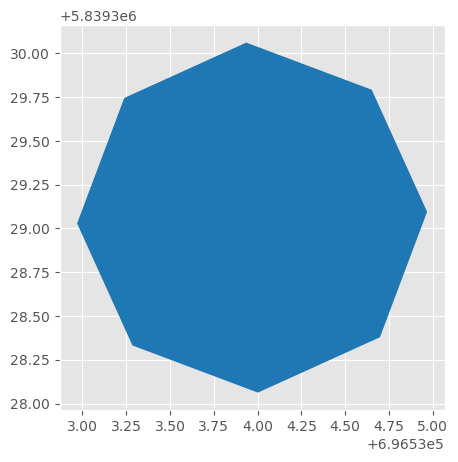

In [8]:
# display a few samples
sample_gdf = aoi_obs_gdf[0:1]
sample_gdf.plot(column='orig_abundance', categorical=False, legend=False)
plt.show()

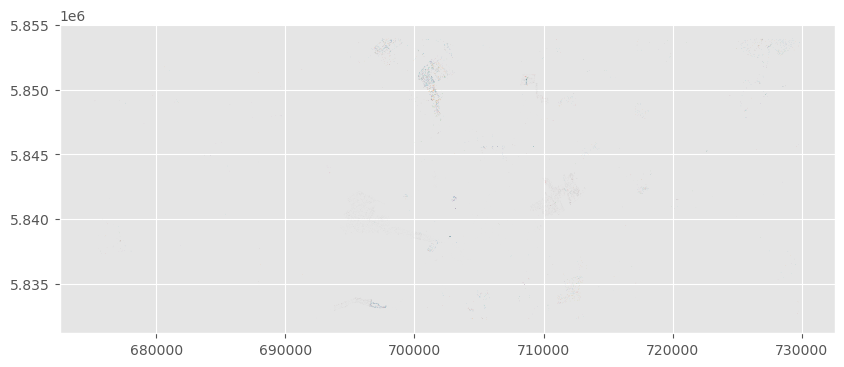

In [9]:
# display all species observations (this might take a while to draw)
aoi_obs_gdf.plot(column='sci_name', categorical=False, legend=False)
plt.show()

In [10]:
# or use explore(), but not for large datasets
aoi_obs_gdf.explore()

### Create a Spark DataFrame
Here comes the more tricky part to lift the GeoDataFrame into a Spark (distributed) DataFrame.

In [11]:
# take a small sample to experiment with
source_gdf = aoi_obs_gdf.copy()

# have to convert the geometry objects (back) to wkt strings for Spark compatibility
source_gdf['wkt'] = pd.Series(
    source_gdf['geometry'].map(lambda x: str(x.wkt), na_action='ignore'),
    index=source_gdf.index, dtype='string'
)

# get rid of the geometry objects that Spark can not automatically interpret
source_gdf.drop(columns=['geometry'], axis=1, inplace=True)

# now create a Spark DataFrame from the GeoPandas DataFrame
obs_sdf = spark.createDataFrame(data=source_gdf)
obs_sdf.printSchema()

root
 |-- nl_name: string (nullable = true)
 |-- sci_name: string (nullable = true)
 |-- jaar: long (nullable = true)
 |-- countsubject: string (nullable = true)
 |-- orig_abundance: string (nullable = true)
 |-- straal: long (nullable = true)
 |-- wkt: string (nullable = true)


In [12]:
obs_sdf.show(10, truncate=True)

+-----------+--------------------+----+----------------+--------------+------+--------------------+
|    nl_name|            sci_name|jaar|    countsubject|orig_abundance|straal|                 wkt|
+-----------+--------------------+----+----------------+--------------+------+--------------------+
| Boomklever|      Sitta europaea|2016|     territorium|             1|     3|POLYGON ((696534....|
|Boomkruiper|Certhia brachydac...|2016|     territorium|             1|     3|POLYGON ((696593....|
|   Zwartkop|  Sylvia atricapilla|2016|     territorium|             1|     3|POLYGON ((696559....|
|Grauwe gans|         Anser anser|2016|     territorium|             1|     3|POLYGON ((708429....|
| Boompieper|    Anthus trivialis|2016|     territorium|             1|     3|POLYGON ((695002....|
|Grauwe gans|         Anser anser|2016|     territorium|             1|   283|POLYGON ((701798....|
|Tuinfluiter|        Sylvia borin|2016|     territorium|             1|     3|POLYGON ((710751....|


In [13]:
# now we can put Spark to work ...
obs_sdf.select("sci_name", "orig_abundance", 'straal').summary().show()

23/07/28 11:31:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+
|summary|          sci_name|    orig_abundance|            straal|
+-------+------------------+------------------+------------------+
|  count|             11551|             11551|             11551|
|   mean|              null|1.1930568781923643| 80.34507834819496|
| stddev|              null| 5.059212018462981|123.55572783291228|
|    min|Accipiter gentilis|                 1|                 3|
|    25%|              null|               1.0|                 3|
|    50%|              null|               1.0|                 3|
|    75%|              null|               1.0|               283|
|    max| Vanellus vanellus|                95|               488|
+-------+------------------+------------------+------------------+


In [14]:
from pyspark.sql.functions import countDistinct

(obs_sdf
    .groupBy("countsubject", "straal")
    .agg(countDistinct("sci_name"))
    .sort('countsubject')
    .show(25, truncate=False)
 )

+--------------------------+------+---------------+
|countsubject              |straal|count(sci_name)|
+--------------------------+------+---------------+
|broedpaar                 |312   |2              |
|broedpaar                 |71    |1              |
|broedpaar                 |488   |2              |
|broedpaar                 |204   |1              |
|broedpaar                 |283   |5              |
|levend exemplaar          |71    |58             |
|levend exemplaar          |283   |96             |
|levend exemplaar          |25    |7              |
|levend exemplaar          |407   |1              |
|nest                      |283   |28             |
|nest                      |71    |11             |
|onbekend                  |102   |1              |
|territorium               |3     |108            |
|territorium               |283   |94             |
|vers gesleep nestmateriaal|283   |10             |
|vers gesleep nestmateriaal|71    |3              |
+-----------

In [15]:
from pyspark.sql.functions import col

(obs_sdf
    .groupBy("countsubject")
    .count()
    .sort(col("count").desc())
    .select("count", "countsubject")
    .show(truncate=False)
 )

+-----+--------------------------+
|count|countsubject              |
+-----+--------------------------+
|10235|territorium               |
|1204 |levend exemplaar          |
|81   |nest                      |
|16   |broedpaar                 |
|14   |vers gesleep nestmateriaal|
|1    |onbekend                  |
+-----+--------------------------+


In [16]:
(obs_sdf
    .groupBy("orig_abundance")
    .count()
    .sort(col("count").desc())
    .select("count", "orig_abundance")
    .show(truncate=False)
 )

+-----+--------------+
|count|orig_abundance|
+-----+--------------+
|11311|1             |
|142  |2             |
|27   |3             |
|22   |4             |
|7    |5             |
|5    |6             |
|4    |10            |
|3    |8             |
|3    |7             |
|2    |12            |
|2    |15            |
|2    |30            |
|2    |156           |
|2    |32            |
|1    |200           |
|1    |16            |
|1    |240           |
|1    |9             |
|1    |11            |
|1    |95            |
+-----+--------------+


### Spark Cleanup (don't forget!)

In [17]:
# stop spark
spark.stop()